# **Proyek Analisis Sentimen: Komentar Video Youtube Jake Paul vs. Mike Tyson FIGHT HIGHLIGHTS 🥊 | ESPN Ringside**

## Import Library

In [18]:
import pandas as pd
import datetime as dt
import re
import string

import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Import NLTK (Natural Language Toolkit).
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\azria\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\azria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\azria\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\azria\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [19]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, Conv1D, GlobalMaxPooling1D, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

In [20]:
# Load dataset from scrapping
yt_comments_df = pd.read_csv('dataset_scraping.csv')

print(f'Row: {yt_comments_df.shape[0]} \nColumn: {yt_comments_df.shape[1]}')
yt_comments_df

Row: 43756 
Column: 5


,comment_id,text,likes,replies,timestamp
0,UgzIeWVXJq6gDc0-kV94AaABAg,این مبارزه در پیری تایسون بود وگرنه تو آمریکا...,0,0,2025-03-27T19:50:24Z
1,UgzXGvvnExI5kkr0-UR4AaABAg,That was scripted,0,0,2025-03-27T14:18:16Z
2,Ugz-YnK-ClO5uBggkPh4AaABAg,Wanna see jack paul vs rodtang,0,0,2025-03-27T12:16:16Z
3,Ugx8n9sspbX6MK_TsNF4AaABAg,This was so bad even the highlights are rubbish,0,0,2025-03-26T23:04:29Z
4,UgwU_Jt5OhKZt1P3QcV4AaABAg,It’s crazy from the first round you can see Mi...,0,0,2025-03-26T14:46:38Z
...,...,...,...,...,...
43751,UgxGPMLwECeBcdVqzAp4AaABAg,Sadly Tyson lost 😢,57,3,2024-11-16T05:58:02Z
43752,UgxxZcwHLgjxAmVHBtd4AaABAg,Garbage fight,212,5,2024-11-16T05:58:00Z
43753,UgyHjn-jBx-IZQGlNwF4AaABAg,mf beatin on someones pa pa...,0,0,2024-11-16T05:57:51Z
43754,UgxsWZcJyaHruYkF5MR4AaABAg,jake won :(,4,0,2024-11-16T05:57:38Z


## Preprocessing

In [21]:
# check for missing value and duplicated rows
print(f'Missing value: \n{yt_comments_df.isna().sum()}\n')
print(f'Duplicate value: {yt_comments_df.duplicated().sum()}\n')

clean_df = yt_comments_df.dropna()
clean_df = yt_comments_df.drop_duplicates()

clean_df.info()

Missing value: 
comment_id    0
text          5
likes         0
replies       0
timestamp     0
dtype: int64

Duplicate value: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43756 entries, 0 to 43755
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   comment_id  43756 non-null  object
 1   text        43751 non-null  object
 2   likes       43756 non-null  int64 
 3   replies     43756 non-null  int64 
 4   timestamp   43756 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.7+ MB


In [22]:
def preprocess_dataframe(df):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Predefined names to remove (lowercased for consistency)
    predefined_names = {"mike", "tyson", "jake", "paul", "logan", "floyd", "mayweather", "conor", "mcgregor"}

    def clean_text(text):
        text = text.lower()  # Casefolding
        text = re.sub(r'@[A-Za-z0-9_]+', '', text)  # Remove mentions
        text = re.sub(r'#[A-Za-z0-9_]+', '', text)  # Remove hashtags
        text = re.sub(r'RT[\s]', '', text)          # Remove "RT"
        text = re.sub(r"http\S+", "", text)         # Remove URLs
        text = re.sub(r"\d+", "", text)             # Remove numbers
        text = re.sub(r"’|‘|'", "", text)           # Remove quotations
        text = text.translate(str.maketrans("", "", string.punctuation))  # Remove punctuation
        text = re.sub(r"\s+", " ", text).strip()    # Remove excess spaces

        # Tokenization
        tokens = word_tokenize(text)

        # Remove predefined names
        tokens = [word for word in tokens if word not in predefined_names]

        # Filtering stopwords
        tokens = [word for word in tokens if word not in stop_words]

        # Lemmatization
        tokens = [lemmatizer.lemmatize(word) for word in tokens]

        return " ".join(tokens)

    df['clean_text'] = df['text'].apply(clean_text)
    return df

In [23]:
clean_df['text'] = clean_df['text'].astype(str)
yt_comments_df = preprocess_dataframe(clean_df)
yt_comments_df

,comment_id,text,likes,replies,timestamp,clean_text
0,UgzIeWVXJq6gDc0-kV94AaABAg,این مبارزه در پیری تایسون بود وگرنه تو آمریکا...,0,0,2025-03-27T19:50:24Z,این مبارزه در پیری تایسون بود وگرنه تو آمریکای...
1,UgzXGvvnExI5kkr0-UR4AaABAg,That was scripted,0,0,2025-03-27T14:18:16Z,scripted
2,Ugz-YnK-ClO5uBggkPh4AaABAg,Wanna see jack paul vs rodtang,0,0,2025-03-27T12:16:16Z,wan na see jack v rodtang
3,Ugx8n9sspbX6MK_TsNF4AaABAg,This was so bad even the highlights are rubbish,0,0,2025-03-26T23:04:29Z,bad even highlight rubbish
4,UgwU_Jt5OhKZt1P3QcV4AaABAg,It’s crazy from the first round you can see Mi...,0,0,2025-03-26T14:46:38Z,crazy first round see far ahead skill talent w...
...,...,...,...,...,...,...
43751,UgxGPMLwECeBcdVqzAp4AaABAg,Sadly Tyson lost 😢,57,3,2024-11-16T05:58:02Z,sadly lost 😢
43752,UgxxZcwHLgjxAmVHBtd4AaABAg,Garbage fight,212,5,2024-11-16T05:58:00Z,garbage fight
43753,UgyHjn-jBx-IZQGlNwF4AaABAg,mf beatin on someones pa pa...,0,0,2024-11-16T05:57:51Z,mf beatin someone pa pa
43754,UgxsWZcJyaHruYkF5MR4AaABAg,jake won :(,4,0,2024-11-16T05:57:38Z,


## Labelling

In [24]:
# Labelling using Vader Lexicon
def label_sentiment(df):
    sia = SentimentIntensityAnalyzer()

    # 🥊 Expanded Fight, Internet Slang, and Trash Talk Lexicon
    custom_words = {
        # 🔥 Positive Fight Slang
        "ko": 2.5,         # Knockout (big win)
        "tko": 2.2,        # Technical knockout (still dominant)
        "dub": 2.0,        # Win (short for W)
        "clutch": 2.0,     # Pulled through under pressure
        "underdog": 2.2,   # Fighter who overcomes odds
        "goat": 2.7,       # Greatest of All Time
        "brawler": 1.8,    # Aggressive fighter
        "counterpuncher": 2.0, # Smart defensive fighter
        "precision": 1.8,  # Accurate striker
        "unstoppable": 2.5, # Dominant fighter
        "footwork": 2.2,   # Good movement in the ring
        "dominant": 2.3,   # Controlling the fight
        "elite": 2.7,      # High-level skill
        "resilient": 2.3,  # Fighter never gives up
        "hyped": 2.0,      # Good anticipation for fight
        "grit": 2.2,       # Fighting through adversity

        # 😡 Negative Fight Slang & Trash Talk
        "rigged": -3.2,    # Match fixing accusation
        "scripted": -3.5,  # Fake fight
        "washed": -2.8,    # Fighter past their prime
        "bum": -3.0,       # Weak fighter
        "cherry-picked": -2.7, # Fighting weak opponents
        "overhyped": -2.5, # Fighter is not as good as advertised
        "exposed": -2.8,   # Fighter got outclassed
        "cooked": -3.2,    # Completely defeated
        "clown": -2.8,     # Mocking a fighter
        "hugging": -2.5,   # Holding opponent instead of fighting
        "robbery": -3.5,   # Bad judge decision
        "ducking": -3.0,   # Avoiding strong opponents
        "scared": -3.0,    # Avoiding action
        "fumble": -2.5,    # Choking under pressure
        "fluke": -2.7,     # Lucky win
        "lame": -2.2,      # Boring fight
        "fraud": -3.5,     # Overrated fighter

        # 💀 Profanity & Strong Language
        "mf": -3.5,        # Motherf***er (insulting)
        "wtf": -2.5,       # Shock or anger
        "bs": -2.2,        # Bullsh*t (negative)
        "nah": -1.5,       # Disagreement
        "damn": -1.5,      # Frustration
        "stfu": -3.2,      # Shut the f*** up (very negative)
        "fu": -3.5,        # F*** you (highly negative)
        "ass": -2.0,       # Insult
        "trash": -2.8,     # Very bad

        # 🎭 Internet & Meme Lingo (Fight Related)
        "w": 2.2,         # Win
        "l": -3.0,        # Loss
        "ratio": -2.5,    # Mocking someone
        "mid": -1.8,      # Mediocre performance
        "npc": -2.5,      # Unoriginal fighter
        "alpha": 1.8,     # Dominant personality
        "sigma": 1.5,     # Lone wolf mindset
        "rizz": 1.8,      # Charisma (used for media presence)
        "gg": 1.5,        # Good game (respectful)
        "bozo": -2.5,     # Insult
        "glazing": -2.8,  # Overhyping a fighter
        "copium": -1.8,   # Coping with a loss
    }

    # Update lexicon
    sia.lexicon.update(custom_words)

    def get_sentiment(text):
        score = sia.polarity_scores(text)['compound']
        if score >= 0.05:
            return "positive"
        elif score <= -0.05:
            return "negative"
        else:
            return "neutral"

    df['sentiment'] = df['clean_text'].apply(get_sentiment)
    return df

In [25]:
yt_comments_df = label_sentiment(yt_comments_df)
yt_comments_df

,comment_id,text,likes,replies,timestamp,clean_text,sentiment
0,UgzIeWVXJq6gDc0-kV94AaABAg,این مبارزه در پیری تایسون بود وگرنه تو آمریکا...,0,0,2025-03-27T19:50:24Z,این مبارزه در پیری تایسون بود وگرنه تو آمریکای...,neutral
1,UgzXGvvnExI5kkr0-UR4AaABAg,That was scripted,0,0,2025-03-27T14:18:16Z,scripted,negative
2,Ugz-YnK-ClO5uBggkPh4AaABAg,Wanna see jack paul vs rodtang,0,0,2025-03-27T12:16:16Z,wan na see jack v rodtang,neutral
3,Ugx8n9sspbX6MK_TsNF4AaABAg,This was so bad even the highlights are rubbish,0,0,2025-03-26T23:04:29Z,bad even highlight rubbish,negative
4,UgwU_Jt5OhKZt1P3QcV4AaABAg,It’s crazy from the first round you can see Mi...,0,0,2025-03-26T14:46:38Z,crazy first round see far ahead skill talent w...,positive
...,...,...,...,...,...,...,...
43751,UgxGPMLwECeBcdVqzAp4AaABAg,Sadly Tyson lost 😢,57,3,2024-11-16T05:58:02Z,sadly lost 😢,negative
43752,UgxxZcwHLgjxAmVHBtd4AaABAg,Garbage fight,212,5,2024-11-16T05:58:00Z,garbage fight,negative
43753,UgyHjn-jBx-IZQGlNwF4AaABAg,mf beatin on someones pa pa...,0,0,2024-11-16T05:57:51Z,mf beatin someone pa pa,negative
43754,UgxsWZcJyaHruYkF5MR4AaABAg,jake won :(,4,0,2024-11-16T05:57:38Z,,neutral


## Visualization

### Sentiment Distribution

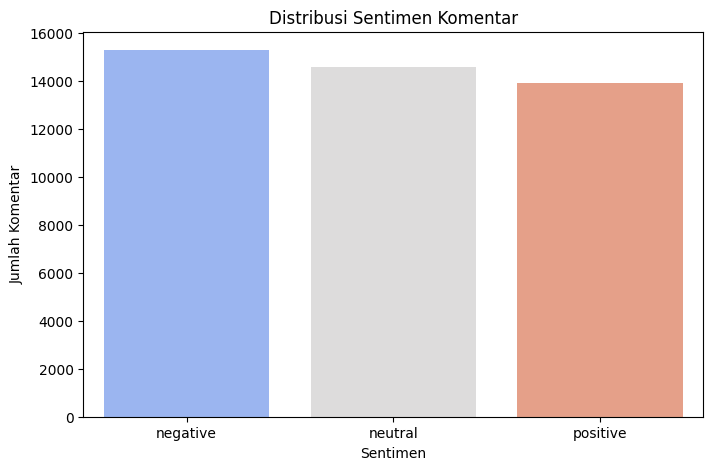

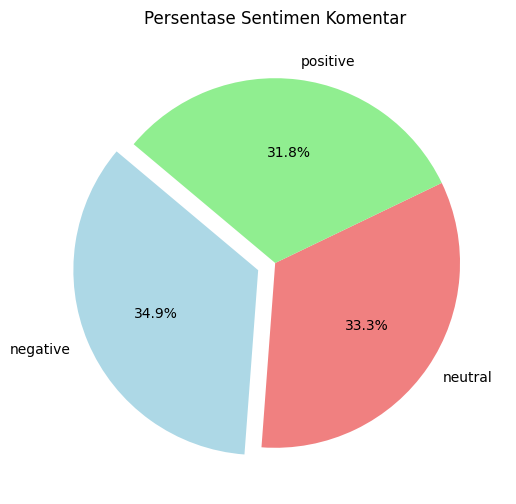


Statistik Rata-rata per Sentimen:
               likes   replies
sentiment                     
negative   22.123274  0.274619
neutral    10.900261  0.131705
positive   44.622598  0.367254


In [26]:
def explore_data(df):
    # count sentiment distribution
    sentiment_counts = df['sentiment'].value_counts()

    # Plot bar chart
    plt.figure(figsize=(8, 5))
    sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='coolwarm', hue=sentiment_counts.index, legend=False)
    plt.title("Distribusi Sentimen Komentar")
    plt.xlabel("Sentimen")
    plt.ylabel("Jumlah Komentar")
    plt.show()

    # Determine the highest percentage sentiment
    max_index = sentiment_counts.idxmax()
    explode_values = [0.1 if sentiment == max_index else 0 for sentiment in sentiment_counts.index]

    # Plot pie chart with explode
    plt.figure(figsize=(6, 6))
    plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%',
            colors=["lightblue", "lightcoral", "lightgreen"], explode=explode_values, startangle=140)
    plt.title("Persentase Sentimen Komentar")
    plt.show()

    # Basic statistic
    sentiment_stats = df.groupby('sentiment')[['likes', 'replies']].mean()
    print("\nStatistik Rata-rata per Sentimen:")
    print(sentiment_stats)

explore_data(yt_comments_df)

### Word Cloud

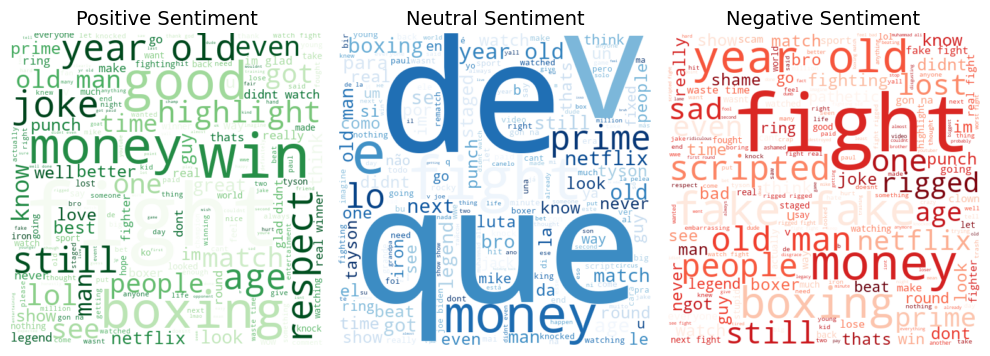

In [27]:
# joinning text based on sentiment
text_positive = ' '.join(yt_comments_df[yt_comments_df['sentiment'] == 'positive']['clean_text'])
text_neutral = ' '.join(yt_comments_df[yt_comments_df['sentiment'] == 'neutral']['clean_text'])
text_negative = ' '.join(yt_comments_df[yt_comments_df['sentiment'] == 'negative']['clean_text'])

# color of each sentiment
colors = ["Greens", "Blues", "Reds"]
titles = ["Positive Sentiment", "Neutral Sentiment", "Negative Sentiment"]
texts = [text_positive, text_neutral, text_negative]

# plot horizontally
fig, axes = plt.subplots(ncols=3, figsize=(10, 6))

for ax, text, title, color in zip(axes, texts, titles, colors):
    wordcloud = WordCloud(width=500, height=500, colormap=color, background_color='white').generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(title, fontsize=14)
    ax.axis("off")

plt.tight_layout()
plt.show()

## Modelling

### Data Splitting for Each Scheme

In [28]:
# set random seed
import tensorflow as tf

df = yt_comments_df

np.random.seed(42)
tf.random.set_seed(42)

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['sentiment'])

# Data Splitting (Skema 1 & 2 - 80/20, Skema 3 - 70/30)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(df['clean_text'], df['label'], test_size=0.2, random_state=42)
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(df['clean_text'], df['label'], test_size=0.3, random_state=42)

### Tokenization and Feature Extraction

In [29]:
# Tokenization
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_text'])

# Convert text to sequences
X_train_seq_1 = pad_sequences(tokenizer.texts_to_sequences(X_train_1), maxlen=100)
X_test_seq_1 = pad_sequences(tokenizer.texts_to_sequences(X_test_1), maxlen=100)

# TF-IDF Embeddings for Skema 3 (70/30)
vectorizer_3 = TfidfVectorizer(max_features=5000)
X_train_tfidf_3 = vectorizer_3.fit_transform(X_train_3).toarray()
X_test_tfidf_3 = vectorizer_3.transform(X_test_3).toarray()

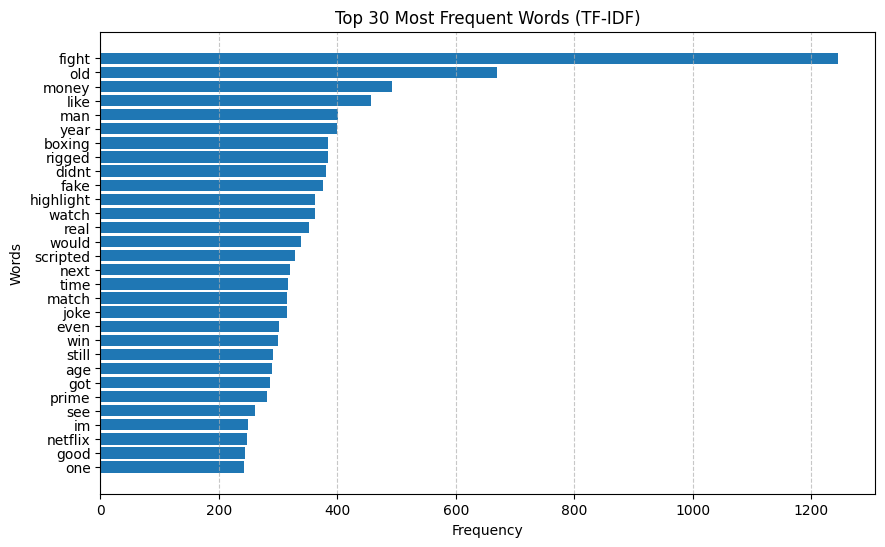

In [30]:
from collections import Counter

# Take feature names from vectorizer (TF-IDF)
feature_names = vectorizer_3.get_feature_names_out()
word_frequencies = np.asarray(X_train_tfidf_3.sum(axis=0)).flatten()

# Create dictionary dictionary (word -> frequency)
word_freq_dict = dict(zip(feature_names, word_frequencies))
top_30_words = Counter(word_freq_dict).most_common(30)

# Seperate words and counts
words, counts = zip(*top_30_words)

# Plot bar
plt.figure(figsize=(10, 6))
plt.barh(words, counts)
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Top 30 Most Frequent Words (TF-IDF)")
plt.gca().invert_yaxis()  # Membalik sumbu Y agar kata paling sering ada di atas
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

### Callback

In [31]:
# Custom Callback for Accuracy Threshold
class AccuracyThresholdCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}  # ensuring logs isn't none
        val_acc = logs.get('val_accuracy')

        if val_acc is not None and val_acc >= 0.94:
            print(f"\nValidation accuracy has reached 94%, stopping training at epoch {epoch+1}.")
            self.model.stop_training = True

# Callback with Modification
callback = [
    EarlyStopping(monitor='val_accuracy', patience=3, mode='max', restore_best_weights=True, min_delta=0.001),
    AccuracyThresholdCallback()
]

### Skema 1: Simple RNN + Trainable Embedding, Data Splitting 80/20

In [32]:
# Skema 1: Simple RNN + Trainable Embedding
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, trainable=True),  # Word Embedding
    SimpleRNN(128, activation='relu', return_sequences=False),  # Simple RNN Layer
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')  # Output layer for 3 sentiment class
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training data
history = model.fit(X_train_seq_1, y_train_1, validation_data=(X_test_seq_1, y_test_1),
                      epochs=10, batch_size=32, callbacks=callback)

# Evaluate on training and test data
train_loss, train_accuracy = model.evaluate(X_train_seq_1, y_train_1, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test_seq_1, y_test_1, verbose=0)

print(f"Model 1 (Simple RNN + Trainable Embedding, Skema 1) - Training Accuracy: {train_accuracy:.4f}")
print(f"Model 1 (Simple RNN + Trainable Embedding, Skema 1) - Test Accuracy: {test_accuracy:.4f}")

Epoch 1/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.6951 - loss: 0.6741 - val_accuracy: 0.9017 - val_loss: 0.3164
Epoch 2/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.9158 - loss: 0.2735 - val_accuracy: 0.9128 - val_loss: 0.2767
Epoch 3/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.9373 - loss: 0.1968 - val_accuracy: 0.9199 - val_loss: 0.2756
Epoch 4/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.9461 - loss: 0.1745 - val_accuracy: 0.9252 - val_loss: 0.2618
Epoch 5/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.9565 - loss: 0.1407 - val_accuracy: 0.9305 - val_loss: 0.2696
Epoch 6/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.9633 - loss: 0.1168 - val_accuracy: 0.9253 - val_loss: 0.2901
Epoch 7/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.9619 - loss: 0.1236 - val_accuracy: 0.9309 - val_loss: 0.3009
Epoch 8/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.9688 -

### Skema 2: CNN + Trainable Embedding, Data Splitting 80/20

In [33]:
# Skema 2: CNN + Trainable Embedding
model2 = Sequential([
    Embedding(5000, 100, trainable=True), # Embedding
    Conv1D(128, 5, activation='relu'), # CNN layer
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax') # Output layer for 3 sentiment class
])
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training data
history2 = model2.fit(X_train_seq_1, y_train_1, validation_data=(X_test_seq_1, y_test_1),
                      epochs=10, batch_size=32, callbacks=callback)

# Evaluate on training and test data
train_loss2, train_accuracy2 = model2.evaluate(X_train_seq_1, y_train_1, verbose=0)
test_loss2, test_accuracy2 = model2.evaluate(X_test_seq_1, y_test_1, verbose=0)

print(f"Model 2 (CNN + Trainable Embedding, Skema 2) - Training Accuracy: {train_accuracy2:.4f}")
print(f"Model 2 (CNN + Trainable Embedding, Skema 2) - Test Accuracy: {test_accuracy2:.4f}")

Epoch 1/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.7420 - loss: 0.5962 - val_accuracy: 0.9084 - val_loss: 0.2683
Epoch 2/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.9315 - loss: 0.2059 - val_accuracy: 0.9218 - val_loss: 0.2492
Epoch 3/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9609 - loss: 0.1250 - val_accuracy: 0.9213 - val_loss: 0.2894
Epoch 4/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9764 - loss: 0.0752 - val_accuracy: 0.9162 - val_loss: 0.3494
Epoch 5/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9841 - loss: 0.0528 - val_accuracy: 0.9151 - val_loss: 0.4027
Model 2 (CNN + Trainable Embedding, Skema 2) - Training Accuracy: 0.9666
Model 2 (CNN + Trainable Embedding, Skema 2) - Test Accuracy: 0.9218


### Skema 3: Logistic Regression + TF-IDF, Data Splitting 70/30

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Skema 3: Logistic Regression + TF-IDF, Data Splitting 70/30
model3 = LogisticRegression(max_iter=500, solver='lbfgs', random_state=42)
model3.fit(X_train_tfidf_3, y_train_3)

# Prediction
y_train_pred_3 = model3.predict(X_train_tfidf_3)
y_test_pred_3 = model3.predict(X_test_tfidf_3)

# Evaluate on training and test data
train_accuracy3 = accuracy_score(y_train_3, y_train_pred_3)
test_accuracy3 = accuracy_score(y_test_3, y_test_pred_3)

print(f"Model 3 (Logistic Regression + TF-IDF, Skema 3) - Training Accuracy: {train_accuracy3:.4f}")
print(f"Model 3 (Logistic Regression + TF-IDF, Skema 3) - Test Accuracy: {test_accuracy3:.4f}")

Model 3 (Logistic Regression + TF-IDF, Skema 3) - Training Accuracy: 0.9017
Model 3 (Logistic Regression + TF-IDF, Skema 3) - Test Accuracy: 0.8694


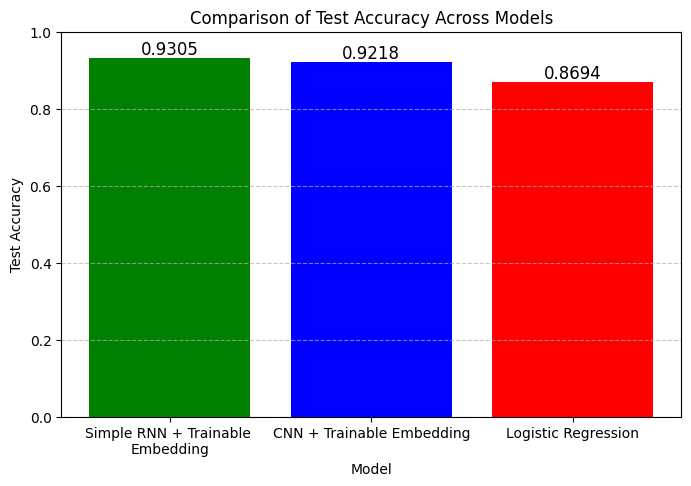

In [35]:
# Model names and test accuracies
models = ['Simple RNN + Trainable \nEmbedding', 'CNN + Trainable Embedding', 'Logistic Regression']
test_accuracies = [test_accuracy, test_accuracy2, test_accuracy3]

# Plot bar chart
plt.figure(figsize=(8, 5))
plt.bar(models, test_accuracies, color=['green', 'blue', 'red'])

# Add value above bar
for i, acc in enumerate(test_accuracies):
    plt.text(i, acc + 0.01, f"{acc:.4f}", ha='center', fontsize=12)

# Label and Title
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.title('Comparison of Test Accuracy Across Models')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()


## Save Model

In [37]:
import pickle

# Simpan model RNN dan CNN
model.save('model1_RNN_embedding.keras')
model2.save('model2_CNN_embedding.keras')

# save model logistic regression
with open('model3_logistic_regression_TFIDF.pkl', 'wb') as f:
    pickle.dump(model3, f)

# save label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# save tokenizer
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# save TF-IDF vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer_3, f)